## Implementation Section

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit

In [2]:
train_df = pd.read_csv("train_df.csv", sep=",")
test_df = pd.read_csv("test_df.csv", sep=",")

In [3]:
sort_cols = ["date", "logistieke location id", "crop_type", "fpc_index", "horizon"]

train_df = train_df.sort_values(sort_cols).reset_index(drop=True)
test_df  = test_df.sort_values(sort_cols).reset_index(drop=True)

In [4]:
for col in ["curr_month", "curr_weekday", "curr_weekofyear", "target_month", "target_weekday", "target_weekofyear"]:
    train_df[col] = train_df[col].astype("category")
    test_df[col]  = test_df[col].astype("category")
    test_df[col] = test_df[col].cat.set_categories(train_df[col].cat.categories)

In [5]:
target = "trolleys_target" 

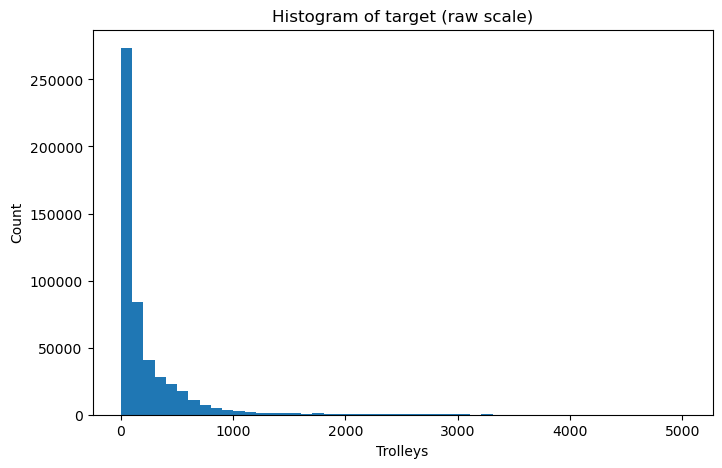

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(train_df[target], bins=50)
plt.xlabel("Trolleys")
plt.ylabel("Count")
plt.title("Histogram of target (raw scale)")
plt.show()

In [7]:
X_train = train_df.drop(columns=[target])
y_train = np.log1p(train_df[target])

X_test = test_df.drop(columns=[target])
y_test = np.log1p(test_df[target])

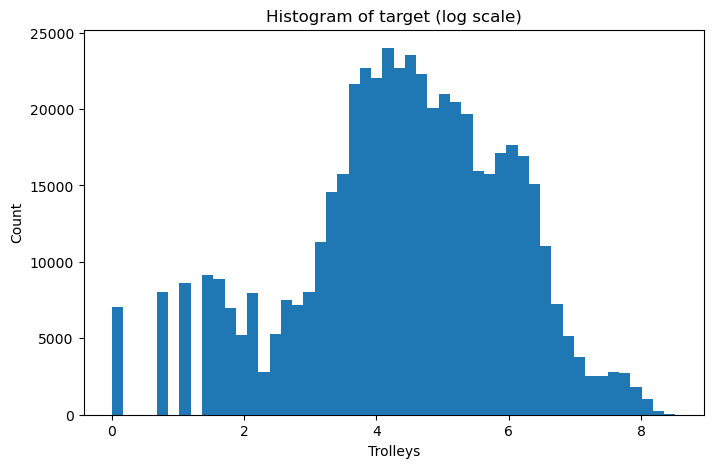

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(y_train, bins=50)
plt.xlabel("Trolleys")
plt.ylabel("Count")
plt.title("Histogram of target (log scale)")
plt.show()

In [9]:
# Drop columns that should never be features
X_train_features = X_train.drop(columns=["date", "target_date"])
X_test_features  = X_test.drop(columns=["date", "target_date"])

# Detect numeric and categorical columns
numeric_cols     = X_train_features.select_dtypes(include=[np.number]).columns
categorical_cols = X_train_features.select_dtypes(exclude=[np.number]).columns
# =========================
# Preprocessing (recipes equivalent)
# =========================

numeric_pipeline = Pipeline([
    ("zv", VarianceThreshold()),                # step_zv()
    ("normalize", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("dummy", OneHotEncoder(                     # step_dummy()
        drop="first",
        sparse_output=False,
        handle_unknown='infrequent_if_exist',
        min_frequency=1
    ))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

In [10]:
def rolling_panel_cv(df, time_col, n_folds, train_blocks):
    # unique, sorted time points from the date column
    times = np.sort(df[time_col].unique())

    # split time points into blocks
    blocks = np.array_split(times, n_folds + train_blocks)

    for i in range(n_folds):
        # define training and test blocks
        train_times = np.concatenate(blocks[i : i + train_blocks])
        test_times = blocks[i + train_blocks]

        # boolean masks for rows belonging to the selected times
        train_mask = df[time_col].isin(train_times)
        test_mask  = df[time_col].isin(test_times)

        # get integer positions for sklearn
        train_idx = np.flatnonzero(train_mask)
        test_idx  = np.flatnonzero(test_mask)

        yield train_idx, test_idx

lambda.min = 0.002364489412645407
lambda.1se = 0.0006428073117284319
1327


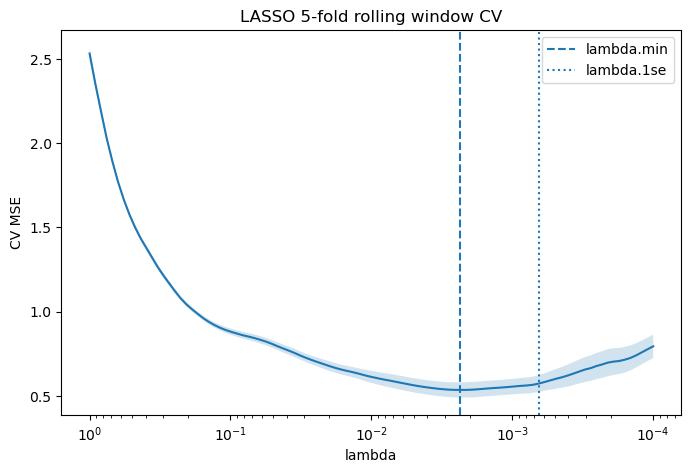

In [12]:
# =========================
# LASSO with 5-fold, rolling window CV
# =========================

cv = list(rolling_panel_cv(
    X_train,
    time_col="date",
    n_folds=5,
    train_blocks=2
))

lasso_cv_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("lasso", LassoCV(
        cv=cv,
        max_iter=30000,
        alphas= np.logspace(-4, 0, 100),
        n_jobs=-1
    ))
])

lasso_cv_pipeline.fit(X_train, y_train)

# =========================
# Extract CV results
# =========================
lasso = lasso_cv_pipeline.named_steps["lasso"]

alphas = lasso.alphas_
mean_mse = lasso.mse_path_.mean(axis=1)
se_mse = lasso.mse_path_.std(axis=1) / np.sqrt(len(cv))

# lambda.min
min_idx = np.argmin(mean_mse)
lambda_min = alphas[min_idx]

# lambda.1se
threshold = mean_mse[min_idx] + se_mse[min_idx]
lambda_1se = alphas[np.where(mean_ <= threshold)[0][-1]]
mse
print(f"lambda.min = {lambda_min}")
print(f"lambda.1se = {lambda_1se}")
print(lasso.n_iter_)

# =========================
# CV plot (glmnet-style)
# =========================
plt.figure(figsize=(8, 5))
plt.semilogx(alphas, mean_mse)
plt.fill_between(alphas, mean_mse - se_mse, mean_mse + se_mse, alpha=0.2)
plt.axvline(lambda_min, linestyle="--", label="lambda.min")
plt.axvline(lambda_1se, linestyle=":", label="lambda.1se")
plt.gca().invert_xaxis()
plt.xlabel("lambda")
plt.ylabel("CV MSE")
plt.title("LASSO 5-fold rolling window CV")
plt.legend()
plt.show()

In [13]:
# =========================
# Refit model using lambda.1se
# =========================
lasso_1se_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("lasso", Lasso(
        alpha=lambda_1se,
        max_iter=10000
    ))
])

lasso_1se_pipeline.fit(X_train, y_train)

# =========================
# Test set evaluation
# =========================
y_pred_log = lasso_1se_pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(test_df[target], y_pred))
mae  = mean_absolute_error(test_df[target], y_pred)

print("\nTest set performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")


Test set performance:
RMSE: 241.8953
MAE : 90.3259


In [14]:
# Make a copy of the test set (optional, avoids modifying original)
test_with_preds = X_test.copy()

# Add your predictions as a new column
test_with_preds["y_pred"] = y_pred

# If you also want the true target in the same dataframe
test_with_preds["y_true"] = test_df[target].values  # make sure indices align

# Peek at the first few rows
test_with_preds = test_with_preds.sort_values(sort_cols).reset_index(drop=True)
test_with_preds.head()

,date,logistieke location id,crop_type,fpc_index,3_avg_price_per_item_lag_1,3_avg_revenue_per_transaction_lag_1,3_items_sold_cv_lag_1,3_items_sold_mean_lag_1,3_items_sold_std_lag_1,3_n_rows_lag_1,...,is_newyear_window,is_allsoulsday_window,is_easter_monday_window,is_whit_monday_window,is_ascension_day_window,is_mothersday_fr_window,is_mothersday_uk_window,is_holiday,y_pred,y_true
0,2023-10-24,Aalsmeer,BL,fpc_1,0.37,153.35,1.22,22783.33,27805.08,3.0,...,1,0,0,0,0,0,0,True,167.180515,353.0
1,2023-10-24,Aalsmeer,BL,fpc_10,0.20,191.20,1.20,4443.81,5313.16,16.0,...,1,0,0,0,0,0,0,True,306.339302,189.0
2,2023-10-24,Aalsmeer,BL,fpc_12,0.24,130.29,1.12,1900.00,2121.32,2.0,...,1,0,0,0,0,0,0,True,20.102776,80.0
3,2023-10-24,Aalsmeer,BL,fpc_13,0.24,73.36,2.16,30315.62,65556.04,8.0,...,1,0,0,0,0,0,0,True,119.660460,280.0
4,2023-10-24,Aalsmeer,BL,fpc_16,0.78,356.79,1.23,14174.29,17480.58,7.0,...,1,0,0,0,0,0,0,True,198.934719,501.0


In [15]:
# Make a copy
agg_test = (
    test_with_preds
    .groupby(["date", "logistieke location id", "crop_type", "horizon"], as_index=False)
    [["y_true", "y_pred"]]
    .sum()
)

# Peek at the result
agg_test.head()

,date,logistieke location id,crop_type,horizon,y_true,y_pred
0,2023-10-24,Aalsmeer,BL,50,8191.0,5998.587135
1,2023-10-24,Aalsmeer,PL,50,2007.0,1346.212101
2,2023-10-24,Naaldwijk,BL,50,2549.0,1856.494477
3,2023-10-24,Naaldwijk,PL,50,1403.0,1022.743259
4,2023-10-24,Rijnsburg,BL,50,1624.0,853.831361


In [16]:
y_test = agg_test['y_true']
y_pred = agg_test['y_pred']

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test))) * 100

print("\nTest set performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


Test set performance:
RMSE: 1034.4906
MAE : 672.7649
MAPE: 23.11%
